# 1. 目的

Multi-Head Attention（多頭注意）は、
異なる観点（head）から系列内の依存関係を学ぶ 仕組みです。

たとえば：

1つのheadは「主語と動詞」の関係を見ている

別のheadは「文の時制」や「修飾関係」を見ている

このように、情報を並列に複数視点で抽出できます。

# 2. 数式の流れ
入力ベクトルを ( X \in \mathbb{R}^{(L, d_{\text{model}})} ) とします。
（L: シーケンス長、d_model: 埋め込み次元）

### (1) Q, K, V を作る

3つの線形変換を行います：

$$
Q = XW_Q, \quad K = XW_K, \quad V = XW_V
$$

ここで
( W_Q, W_K, W_V \in \mathbb{R}^{d_{\text{model}} \times d_k} )

### (2) スコアを計算する

Attentionスコアは次のように求めます：

$$
\text{Attention}(Q,K,V) = \text{softmax}\left(\frac{QK^\top}{\sqrt{d_k}}\right)V
$$

このスコアは「どの単語に注目すべきか」を表します。


### (3) Multi-Head化

上のAttentionを複数headで並列に行い、結合します：

$$
\text{MultiHead}(X) = \text{Concat}(head_1, ..., head_h)W_O
$$

In [1]:
import torch
import torch.nn.functional as F
from torch import nn
import matplotlib.pyplot as plt


class ScaledDotProductAttention(nn.Module):
    def __init__(self):
        super().__init__()

    def forward(self, Q, K, V, mask=None):
        # Q,K,V: [batch, heads, seq_len, head_dim]
        d_k = Q.size(-1)
        scores = (Q @ K.transpose(-2, -1)) / d_k**0.5  # スコア計算
        if mask is not None:
            scores = scores.masked_fill(mask == 0, -1e9)
        attn = F.softmax(scores, dim=-1)
        output = attn @ V
        return output, attn

In [2]:
class MultiHeadAttention(nn.Module):
    def __init__(self, embed_dim, num_heads):
        super().__init__()
        assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"

        self.embed_dim = embed_dim
        self.num_heads = num_heads
        self.head_dim = embed_dim // num_heads

        # Q,K,Vを作る線形層
        self.W_Q = nn.Linear(embed_dim, embed_dim)
        self.W_K = nn.Linear(embed_dim, embed_dim)
        self.W_V = nn.Linear(embed_dim, embed_dim)

        # 出力結合
        self.W_O = nn.Linear(embed_dim, embed_dim)

        self.attention = ScaledDotProductAttention()

    def forward(self, x, mask=None):
        B, L, C = x.size()  # (batch, seq_len, embed_dim)

        # Q,K,V作成して [B, heads, seq_len, head_dim] にreshape
        Q = self.W_Q(x).view(B, L, self.num_heads, self.head_dim).transpose(1, 2)
        K = self.W_K(x).view(B, L, self.num_heads, self.head_dim).transpose(1, 2)
        V = self.W_V(x).view(B, L, self.num_heads, self.head_dim).transpose(1, 2)

        # 各headでAttention
        out, attn = self.attention(Q, K, V, mask=mask)

        # 結果を結合
        out = out.transpose(1, 2).contiguous().view(B, L, C)
        return self.W_O(out), attn

In [3]:
# サンプル入力
batch_size, seq_len, embed_dim, num_heads = 2, 5, 128, 4
x = torch.randn(batch_size, seq_len, embed_dim)

mha = MultiHeadAttention(embed_dim, num_heads)
out, attn = mha(x)

print("出力の形状:", out.shape)
print("Attentionスコア:", attn.shape)

出力の形状: torch.Size([2, 5, 128])
Attentionスコア: torch.Size([2, 4, 5, 5])


In [18]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import math

# 設定値
embed_dim=256
num_heads=4

head_dim = embed_dim // num_heads

assert embed_dim % num_heads == 0, "embed_dim must be divisible by num_heads"

In [19]:
# Q, K ,V の定義
W_q = nn.Linear(embed_dim, embed_dim)
W_k = nn.Linear(embed_dim, embed_dim)
W_v = nn.Linear(embed_dim, embed_dim)

# 入力定義
x = torch.randn(1, 20, embed_dim)
B, L, _ = x.size()

In [20]:
# Q,K,V projection
Q = W_q(x)
K = W_k(x)
V = W_v(x)

Q.shape

torch.Size([1, 20, 256])

In [21]:
# シングルヘッドのアテンション
score = torch.matmul(Q, K.transpose(-1, -2)) / (head_dim ** 0.5)

# Softmax → Attention map
attn_single = torch.softmax(score, dim=-1)   # (B, H, L, L)


In [26]:
# ヘッド文の分割
Q = Q.contiguous().view(B, L, num_heads, head_dim).transpose(1, 2)
K = K.contiguous().view(B, L, num_heads, head_dim).transpose(1, 2)
V = V.contiguous().view(B, L, num_heads, head_dim).transpose(1, 2)

# attention score
score = torch.matmul(Q, K.transpose(-1, -2)) / (head_dim ** 0.5)   # (B, H, L, L)

# Softmax → Attention map
attn_multi = torch.softmax(score, dim=-1)   # (B, H, L, L)

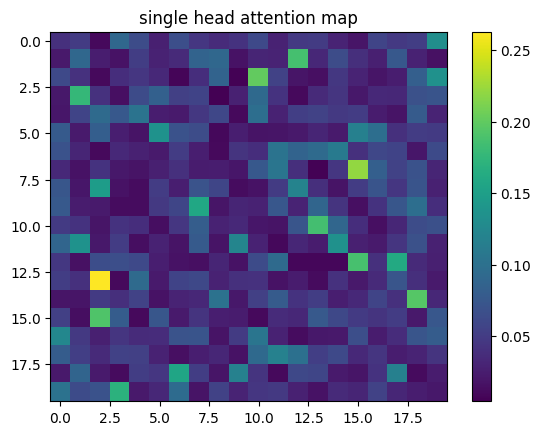

In [36]:
# シングルヘッドのアテンションマップを可視化
plt.imshow(attn_single[0].detach().cpu().numpy(), aspect='auto')
plt.colorbar()
plt.title("single head attention map")
plt.show()

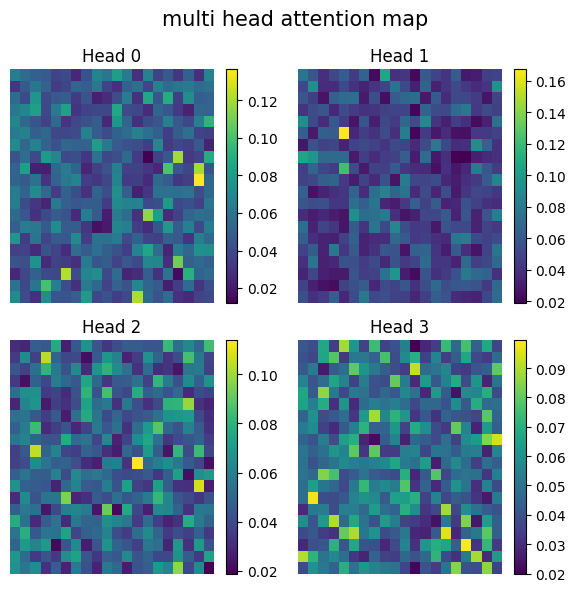

In [37]:
# マルチヘッドアテンションをヘッドごとに表示
cols = math.ceil(math.sqrt(num_heads))
rows = math.ceil(num_heads / cols)

plt.figure(figsize=(3 * cols, 3 * rows))

for h in range(num_heads):
  plt.subplot(rows, cols, h + 1)
  plt.imshow(attn_multi[0, h].cpu().detach().numpy(), aspect='auto')
  plt.title(f"Head {h}")
  plt.colorbar()
  plt.axis("off")


plt.suptitle("multi head attention map", fontsize=15)
plt.tight_layout()
plt.show()